# Compare different FHT filters with analytical solution

In [1]:
import os
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load dipole- and analytical routines; filters
from empymod import dipole, analytical
from empymod import filters

# Plotting style adjustments
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.style'] = 'normal'

# Set axis and limits
def limits(i):
    plt.sca(axs[i])
    plt.xlim(min(x)/1000, max(x)/1000)
    plt.ylim(min(x)/1000, max(x)/1000)
    plt.axis('equal')    

## Model parameters, as in halfspacemod.src from Hunziker et al., 2015

In [2]:
# Define coordinates
x = (np.arange(1051))*10-500
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()
params = {
    'src': [0, 0, 150],
    'rec': [rx.ravel(), ry.ravel(), 200],
    'depth': 0,
    'res': [1e20, 1/3],
    'freqtime': 0.5,
    'ab': 11,
    'aniso': [1, np.sqrt(3/.3)],
    'epermH': [1, 80],
    'epermV': [1, 80],
    'xdirect': False,
    'verb': 0,
}

### Analytical solution

In [3]:
resp = analytical(params['src'], params['rec'], params['res'][1], params['freqtime'],
                  solution='dhs', aniso=params['aniso'][1], ab=params['ab'])
resp = resp.reshape(np.shape(rx))

* WARNING :: Offsets < 0.001 m are set to 0.001 m!

:: empymod END; runtime = 0:00:06.445189 :: 



### Error calculation

In [4]:
def calc_err(params, htarg=None):
    
    # The model is very big (1 million cells), so it gives a very detailed view of the error,
    # as used by Hunziker et al 2015. However, this is more an academic use. On my laptop, all
    # except the lagged FHT would fail due to memory issues. Hence I carry out the calculation
    # in loops. More 'industry'-like values can be seen in Key 2012.
    inpresp = np.zeros(rx.ravel().shape, dtype=complex)
    for i in range(74):
        cc = 15000
        params['rec'] = [rx.ravel()[i*cc:(i+1)*cc], ry.ravel()[i*cc:(i+1)*cc], 200]
        inpresp[i*cc:(i+1)*cc] = dipole(**params, htarg=htarg)
    params['rec'] = [rx.ravel(), ry.ravel(), 200]

    # Reshape and calculate log10-error for phase and amplitude
    inpresp = inpresp.reshape(np.shape(rx))
    amperr = np.abs((np.abs(resp) - np.abs(inpresp))/np.abs(resp))*100
    phaerr = np.abs((np.angle(resp) - np.angle(inpresp))/np.angle(resp))*100
    
    return amperr, phaerr

### Calculate FHTs

In [5]:
if os.path.isfile('./data/FilterComparison.npz'):  # If results exist, load them
    data = np.load('data/FilterComparison.npz')
    fht1amp, fht1pha = data['fht1amp'], data['fht1pha']
    fht2amp, fht2pha = data['fht2amp'], data['fht2pha']
    fht3amp, fht3pha = data['fht3amp'], data['fht3pha']
    fht4amp, fht4pha = data['fht4amp'], data['fht4pha']
    fht5amp, fht5pha = data['fht5amp'], data['fht5pha']
    fht6amp, fht6pha = data['fht6amp'], data['fht6pha']
    fht7amp, fht7pha = data['fht7amp'], data['fht7pha']
    fht8amp, fht8pha = data['fht8amp'], data['fht8pha']
    fht9amp, fht9pha = data['fht9amp'], data['fht9pha']
else:
    print('Kong07-61')
    fht1amp, fht1pha = calc_err(params, htarg=filters.kong_61_2007())
    print('Kong07-241')
    fht2amp, fht2pha = calc_err(params, htarg=filters.kong_241_2007())
    print('Key09-101')
    fht3amp, fht3pha = calc_err(params, htarg=filters.key_101_2009())
    print('Key09-201')
    fht4amp, fht4pha = calc_err(params, htarg=filters.key_201_2009())
    print('Key09-401')
    fht5amp, fht5pha = calc_err(params, htarg=filters.key_401_2009())
    print('Anderson82-801')
    fht6amp, fht6pha = calc_err(params, htarg=filters.anderson_801_1982())
    print('Key12-51')
    fht7amp, fht7pha = calc_err(params, htarg=filters.key_51_2012())
    print('Key12-101')
    fht8amp, fht8pha = calc_err(params, htarg=filters.key_101_2012())
    print('Key12-201')
    fht9amp, fht9pha = calc_err(params, htarg=filters.key_201_2012())
    # Store results
    np.savez('data/FilterComparison.npz',
             fht1amp=fht1amp, fht1pha=fht1pha, fht2amp=fht2amp, fht2pha=fht2pha, fht3amp=fht3amp, fht3pha=fht3pha,
             fht4amp=fht4amp, fht4pha=fht4pha, fht5amp=fht5amp, fht5pha=fht5pha, fht6amp=fht6amp, fht6pha=fht6pha,
             fht7amp=fht7amp, fht7pha=fht7pha, fht8amp=fht8amp, fht8pha=fht8pha, fht9amp=fht9amp, fht9pha=fht9pha)

### Plot amplitude

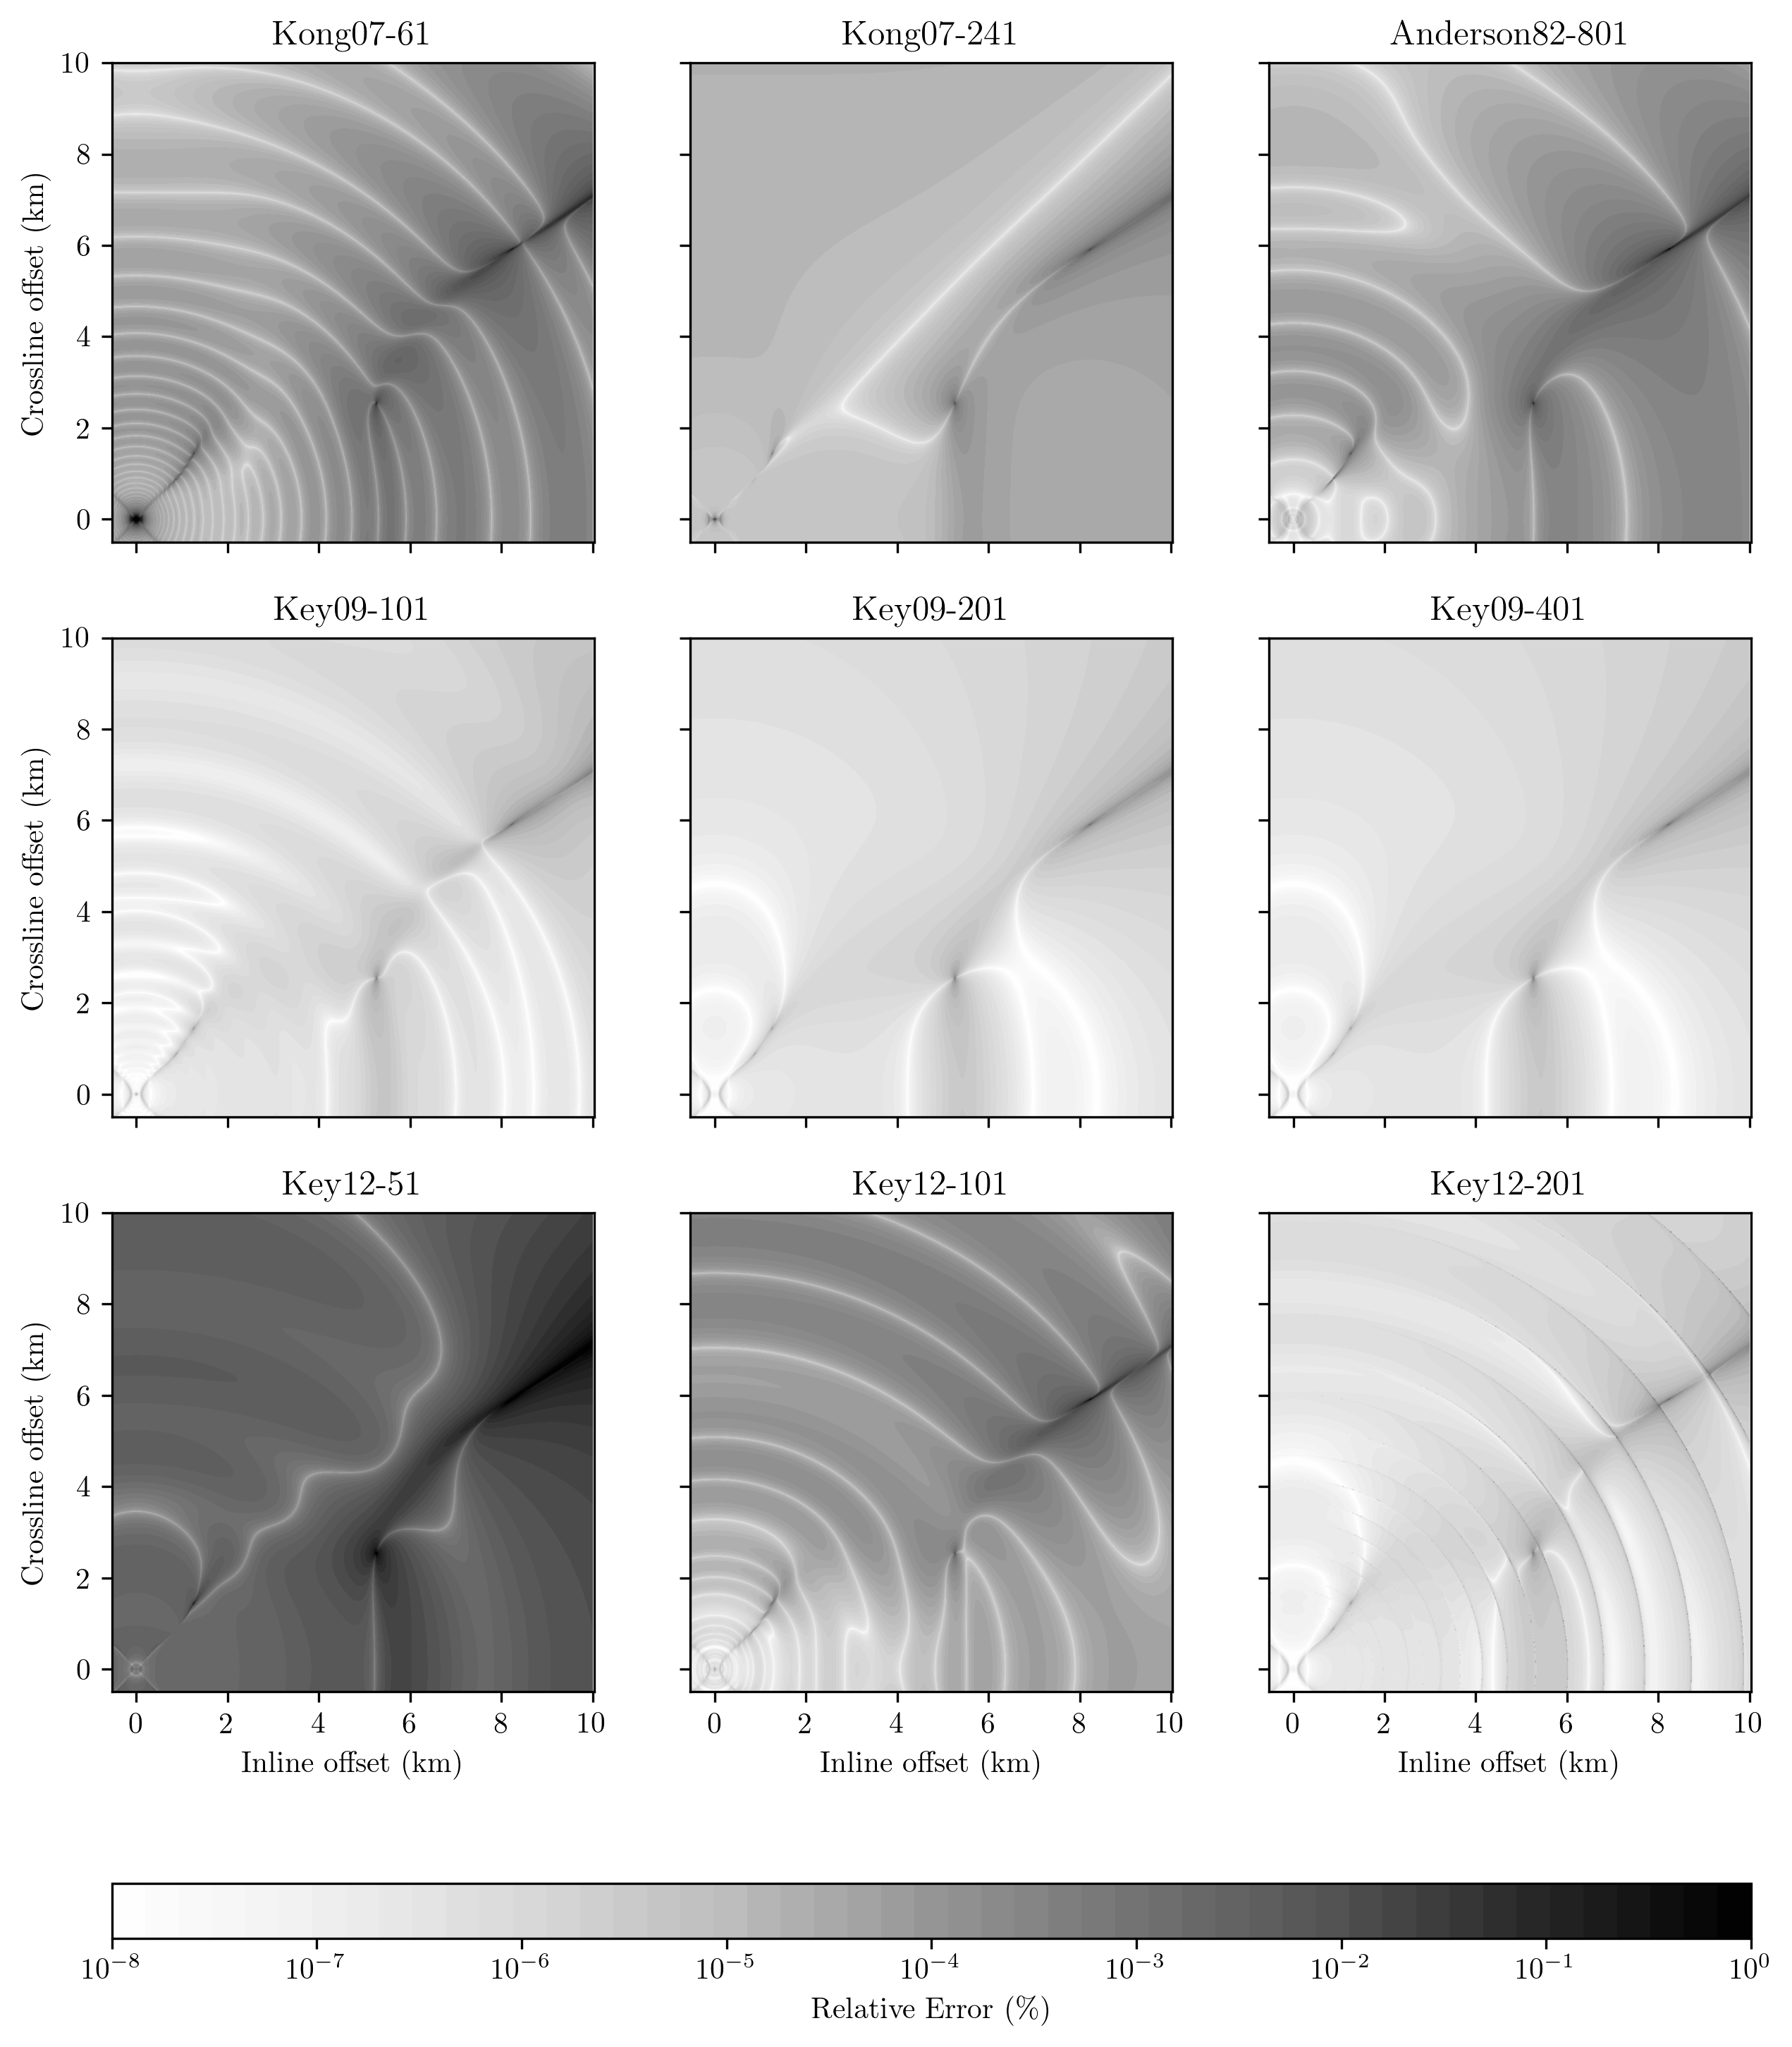

In [6]:
fig, axs = plt.subplots(figsize=(10, 12), facecolor = 'w', nrows=3, ncols=3, sharex=True, sharey=True)
axs = axs.ravel()

# Min and max, properties
vmin = 1e-8
vmax = 1e0
props = {'levels': np.logspace(np.log10(vmin), np.log10(vmax), 50), 'locator': mpl.ticker.LogLocator(), 'cmap': 'Greys'}

limits(0)
plt.title(r'Kong07-61')
cf1 = plt.contourf(rx/1000, ry/1000, fht1amp.clip(vmin, vmax), **props)
plt.ylabel('Crossline offset (km)')

limits(1)
plt.title(r'Kong07-241')
cf2 = plt.contourf(rx/1000, ry/1000, fht2amp.clip(vmin, vmax), **props)

limits(3)
plt.title(r'Key09-101')
cf3 = plt.contourf(rx/1000, ry/1000, fht3amp.clip(vmin, vmax), **props)
plt.ylabel('Crossline offset (km)')

limits(4)
plt.title(r'Key09-201')
cf4 = plt.contourf(rx/1000, ry/1000, fht4amp.clip(vmin, vmax), **props)

limits(5)
plt.title(r'Key09-401')
cf5 = plt.contourf(rx/1000, ry/1000, fht5amp.clip(vmin, vmax), **props)

limits(2)
plt.title(r'Anderson82-801')
cf6 = plt.contourf(rx/1000, ry/1000, fht6amp.clip(vmin, vmax), **props)

limits(6)
plt.title(r'Key12-51')
cf7 = plt.contourf(rx/1000, ry/1000, fht7amp.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')
plt.ylabel('Crossline offset (km)')
plt.xticks(np.arange(6)*2)

limits(7)
plt.title(r'Key12-101')
cf8 = plt.contourf(rx/1000, ry/1000, fht8amp.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')

limits(8)
plt.title(r'Key12-201')
cf9 = plt.contourf(rx/1000, ry/1000, fht9amp.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')

# Plot colorbar
cax, kw = mpl.colorbar.make_axes([axs[0], axs[1], axs[2], axs[3], axs[4], axs[5], axs[6], axs[7], axs[8]],
                                 location='bottom', fraction=.05, pad=0.1, aspect=30)
cb = plt.colorbar(cf8, cax=cax, ticks=10**(-(np.arange(11.)[::-1])+2), **kw)
cb.set_label(r'Relative Error $(\%)$')

# Save and show
plt.savefig('../figures/filtercomp-amplitude.jpg', bbox_inches='tight')
plt.show()

### Plot phase

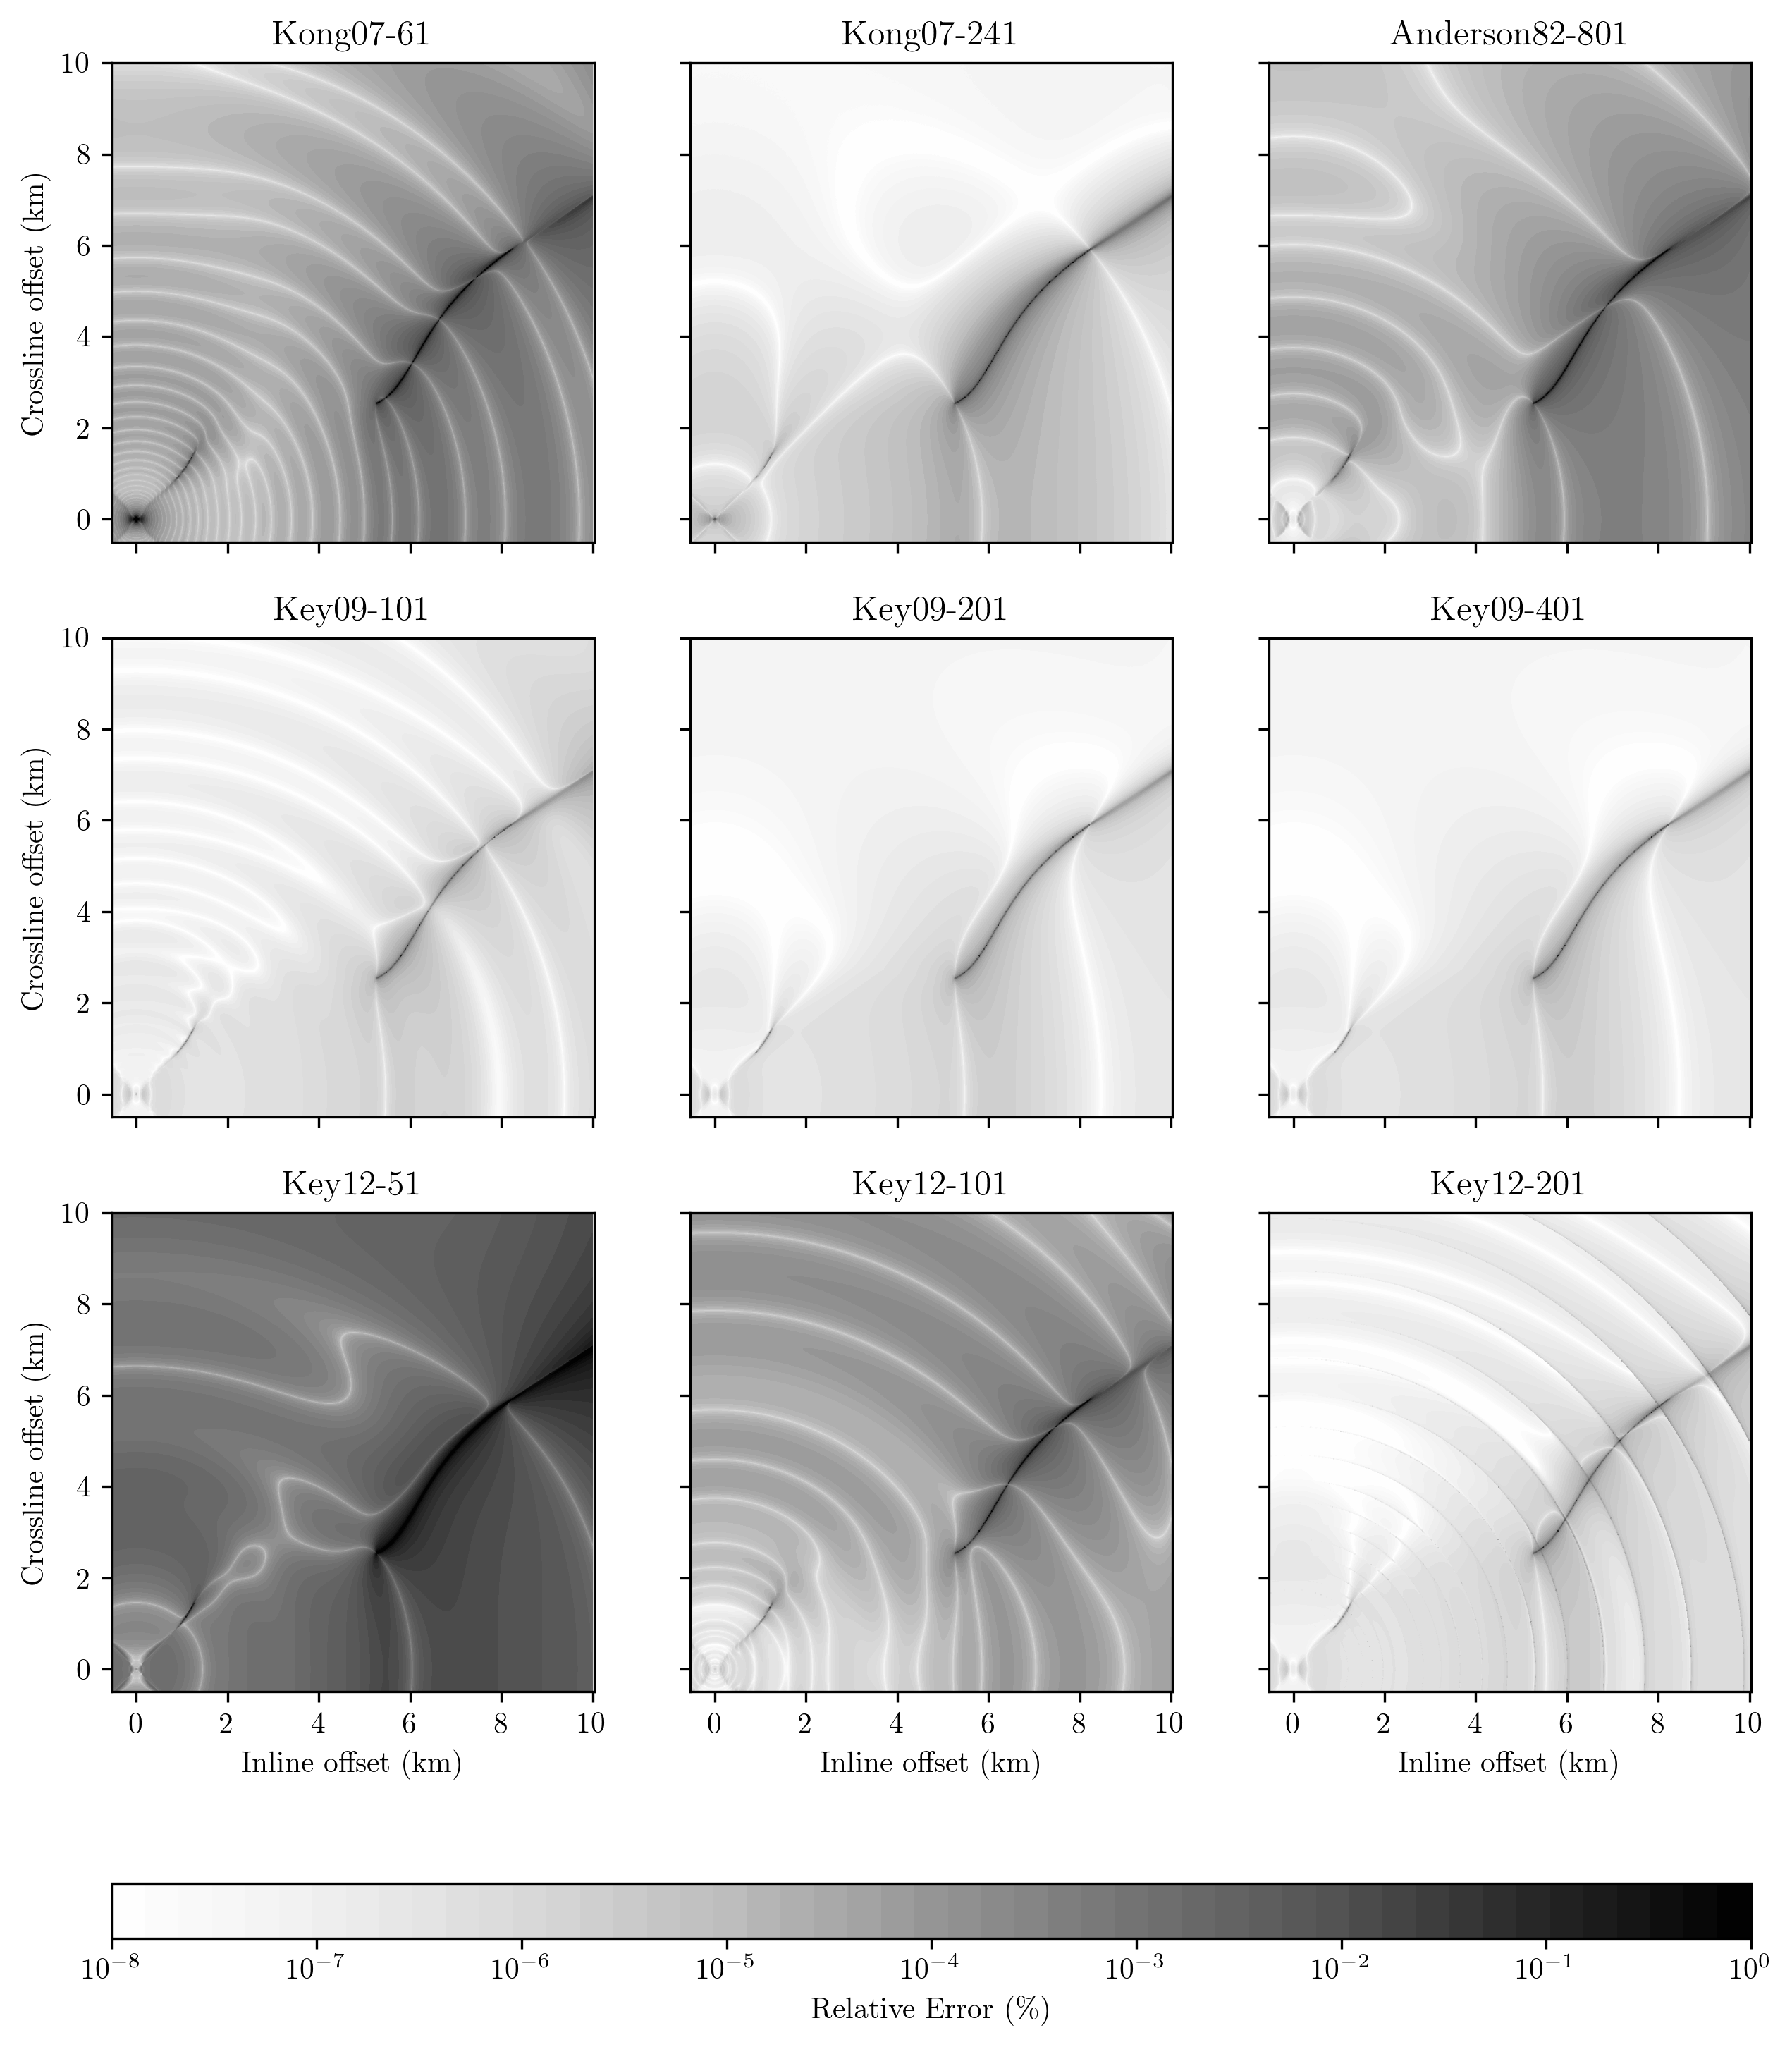

In [7]:
fig, axs = plt.subplots(figsize=(10, 12), facecolor = 'w', nrows=3, ncols=3, sharex=True, sharey=True)
axs = axs.ravel()

# Min and max, properties
vmin = 1e-8
vmax = 1e0
props = {'levels': np.logspace(np.log10(vmin), np.log10(vmax), 50), 'locator': mpl.ticker.LogLocator(), 'cmap': 'Greys'}

limits(0)
plt.title(r'Kong07-61')
cf1 = plt.contourf(rx/1000, ry/1000, fht1pha.clip(vmin, vmax), **props)
plt.ylabel('Crossline offset (km)')

limits(1)
plt.title(r'Kong07-241')
cf2 = plt.contourf(rx/1000, ry/1000, fht2pha.clip(vmin, vmax), **props)

limits(3)
plt.title(r'Key09-101')
cf3 = plt.contourf(rx/1000, ry/1000, fht3pha.clip(vmin, vmax), **props)
plt.ylabel('Crossline offset (km)')

limits(4)
plt.title(r'Key09-201')
cf4 = plt.contourf(rx/1000, ry/1000, fht4pha.clip(vmin, vmax), **props)

limits(5)
plt.title(r'Key09-401')
cf5 = plt.contourf(rx/1000, ry/1000, fht5pha.clip(vmin, vmax), **props)

limits(2)
plt.title(r'Anderson82-801')
cf6 = plt.contourf(rx/1000, ry/1000, fht6pha.clip(vmin, vmax), **props)

limits(6)
plt.title(r'Key12-51')
cf7 = plt.contourf(rx/1000, ry/1000, fht7pha.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')
plt.ylabel('Crossline offset (km)')
plt.xticks(np.arange(6)*2)

limits(7)
plt.title(r'Key12-101')
cf8 = plt.contourf(rx/1000, ry/1000, fht8pha.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')

limits(8)
plt.title(r'Key12-201')
cf9 = plt.contourf(rx/1000, ry/1000, fht9pha.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')

# Plot colorbar
cax, kw = mpl.colorbar.make_axes([axs[0], axs[1], axs[2], axs[3], axs[4], axs[5], axs[6], axs[7], axs[8]],
                                 location='bottom', fraction=.05, pad=0.1, aspect=30)
cb = plt.colorbar(cf8, cax=cax, ticks=10**(-(np.arange(11.)[::-1])+2), **kw)
cb.set_label(r'Relative Error $(\%)$')

# Save and show
plt.savefig('../figures/filtercomp-phase.jpg', bbox_inches='tight')
plt.show()

### Re-define coordinates, so it is a regular grid of 100 m spacing from 0 to 10 km, as in `halfspacemod_100m.scr`

In [8]:
x = (np.arange(101))*100
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()
params['rec'] = [rx.ravel(), ry.ravel(), 200]

### Time of `empymod`

In [9]:
%timeit dipole(**params, htarg=filters.kong_61_2007())
%timeit dipole(**params, htarg=filters.kong_241_2007())
%timeit dipole(**params, htarg=filters.key_101_2009())
%timeit dipole(**params, htarg=filters.key_201_2009())
%timeit dipole(**params, htarg=filters.key_401_2009())
%timeit dipole(**params, htarg=filters.anderson_801_1982())
%timeit dipole(**params, htarg=filters.key_51_2012())
%timeit dipole(**params, htarg=filters.key_101_2012())
%timeit dipole(**params, htarg=filters.key_201_2012())

1 loop, best of 3: 451 ms per loop
1 loop, best of 3: 2.96 s per loop
1 loop, best of 3: 795 ms per loop
1 loop, best of 3: 1.68 s per loop
1 loop, best of 3: 4.68 s per loop
The slowest run took 14.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 5.34 s per loop
1 loop, best of 3: 333 ms per loop
1 loop, best of 3: 653 ms per loop
1 loop, best of 3: 1.27 s per loop


In [10]:
import printinfo
printinfo.info()